# Weather Forecasting Analysis

This notebook implements a machine learning model to predict rainfall based on weather data.

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.grid': True,
    'font.size': 12
})

## 2. Load and Preprocess Data

In [2]:
# Read the CSV file
df = pd.read_csv('weather_data.csv')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# Handle missing values
numeric_columns = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].mean())

# Convert rain_or_not to binary
df['rain_or_not'] = (df['rain_or_not'] == 'Rain').astype(int)

df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             311 non-null    object 
 1   avg_temperature  296 non-null    float64
 2   humidity         296 non-null    float64
 3   avg_wind_speed   296 non-null    float64
 4   rain_or_not      311 non-null    object 
 5   cloud_cover      296 non-null    float64
 6   pressure         311 non-null    float64
dtypes: float64(5), object(2)
memory usage: 17.1+ KB
None

Missing Values:
date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
dtype: int64


,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,1,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,1,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,1,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,1,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,1,38.062329,1030.264331


## 3. Exploratory Data Analysis

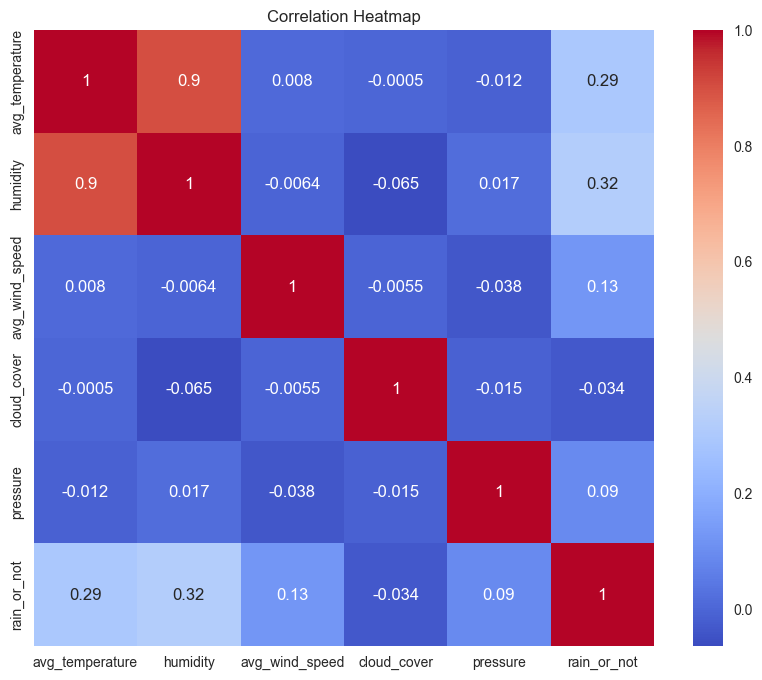

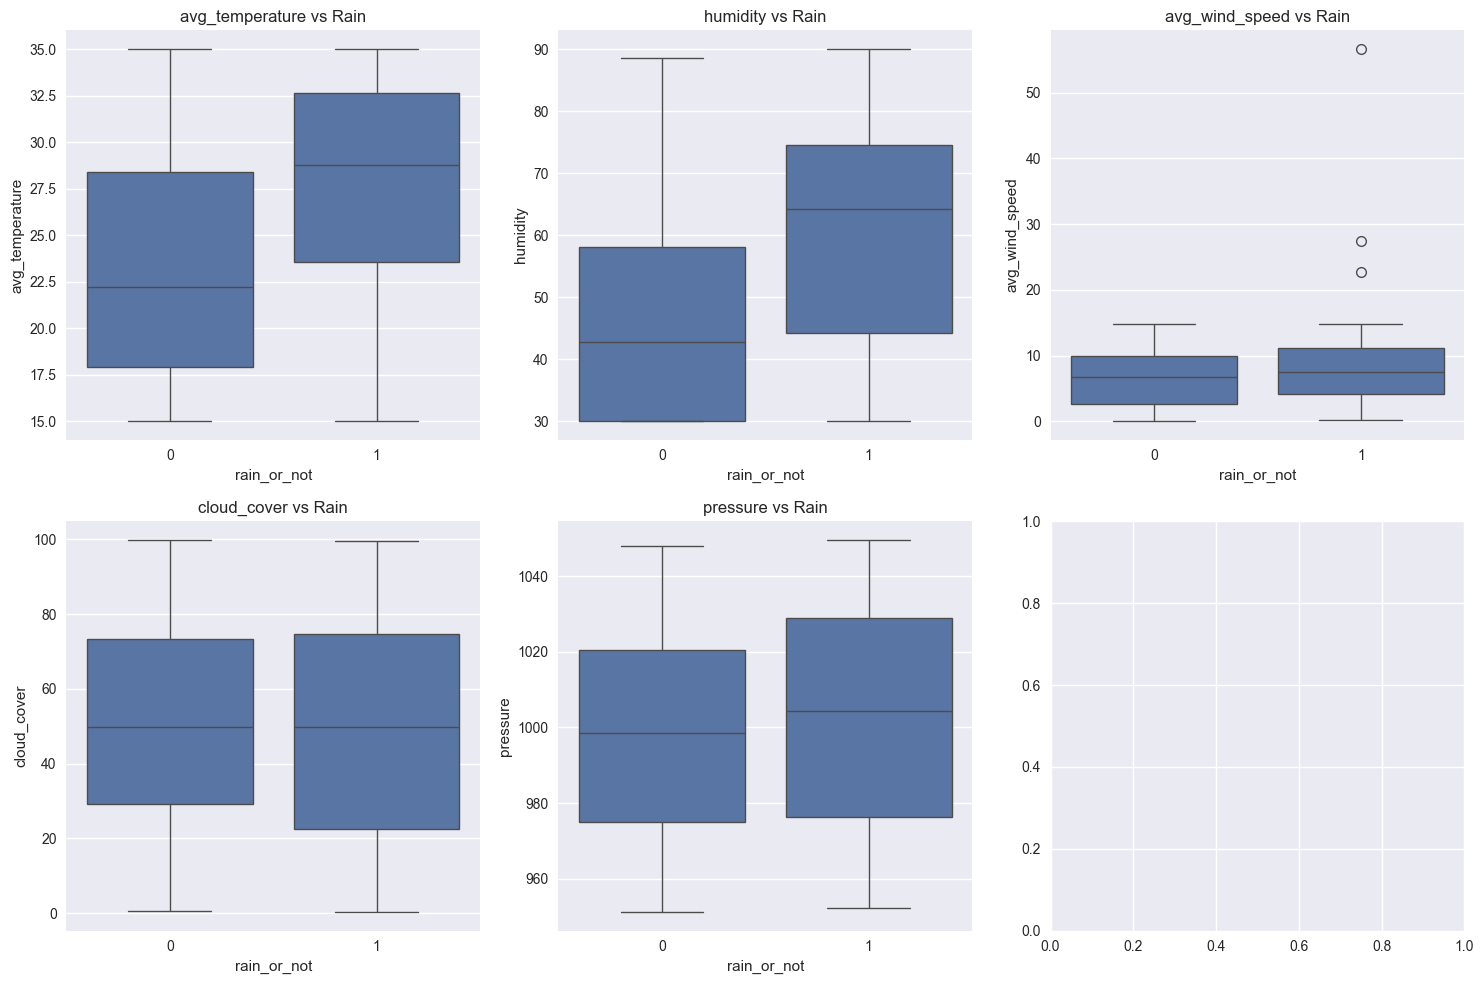

In [3]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
correlation = df[numeric_columns + ['rain_or_not']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_columns):
    sns.boxplot(x='rain_or_not', y=col, data=df, ax=axes[idx])
    axes[idx].set_title(f'{col} vs Rain')

plt.tight_layout()
plt.show()

## 4. Model Training and Optimization

In [4]:
# Prepare data for modeling
X = df[numeric_columns]
y = df['rain_or_not']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize and train model
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_model = grid_search.best_estimator_

## 5. Model Evaluation and Results

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Model Performance:
              precision    recall  f1-score   support

           0       0.38      0.41      0.39        22
           1       0.67      0.63      0.65        41

    accuracy                           0.56        63
   macro avg       0.52      0.52      0.52        63
weighted avg       0.56      0.56      0.56        63


Feature Importance:
           feature  importance
1         humidity    0.223228
4         pressure    0.216010
0  avg_temperature    0.192598
2   avg_wind_speed    0.186955
3      cloud_cover    0.181210


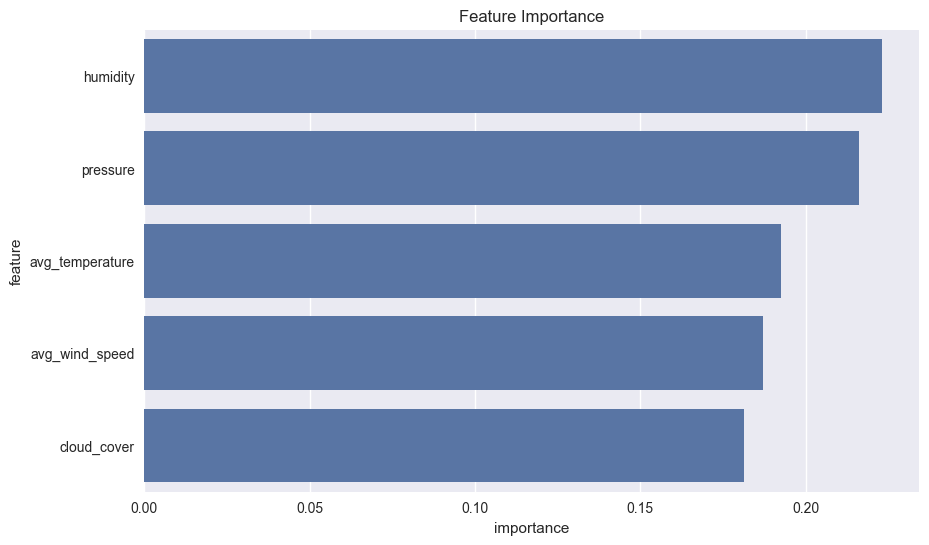

In [5]:
# Make predictions
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)

# Print results
print("Best Parameters:", grid_search.best_params_)
print("\nModel Performance:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': numeric_columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

## 6. Rain Probability Predictions

In [6]:
# Get predictions for last few samples
last_samples = X_test_scaled[-5:]
predictions = best_model.predict_proba(last_samples)

print("Rain Probability for Last 5 Samples:")
for i, prob in enumerate(predictions):
    print(f"Sample {i+1}: {prob[1]:.2%} chance of rain")

Rain Probability for Last 5 Samples:
Sample 1: 55.80% chance of rain
Sample 2: 52.78% chance of rain
Sample 3: 31.99% chance of rain
Sample 4: 95.77% chance of rain
Sample 5: 53.05% chance of rain
